# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [8]:
# number of callbacks for black-sounding names
call_w = sum(data[data.race=='w'].call)
call_b = sum(data[data.race=='b'].call)
total_w = len(data[data.race=='w'])
total_b = len(data[data.race=='b'])
call_tot = sum(data.call)
all_call = len(data.call)
d = {'call_backs':[call_w, call_b, call_tot], 'no_call':[(total_w - call_w), (total_b - call_b), (all_call - call_tot)], 'total':[total_w, total_b, all_call], 'percent':[(call_w/total_w), (call_b/total_b), (call_tot/all_call)]}
df = pd.DataFrame(data=d)
df.index = ['white_sounding_name', 'black_sounding_name', 'total']
print(df)

                     call_backs  no_call  total   percent
white_sounding_name       235.0   2200.0   2435  0.096509
black_sounding_name       157.0   2278.0   2435  0.064476
total                     392.0   4478.0   4870  0.080493


In [5]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [6]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x: sort the data
    x = np.sort(data)

    # y: range for y-axis
    y = np.arange(1, n+1) / n

    return x, y

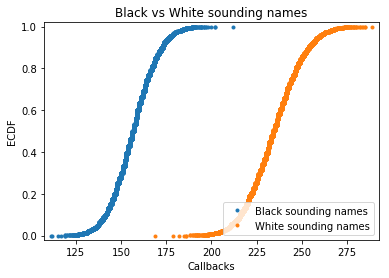

In [11]:
b = data[data.race == 'b']
w = data[data.race == 'w']

b_samples = np.random.binomial(total_b, df.percent.iloc[1], 10000)
w_samples = np.random.binomial(total_w, df.percent.iloc[0], 10000)

b_x, b_y = ecdf(b_samples)
w_x, w_y = ecdf(w_samples)

_ = plt.plot(b_x, b_y, marker='.', linestyle='none')
_ = plt.plot(w_x, w_y, marker='.', linestyle='none')
_ = plt.xlabel('Callbacks')
_ = plt.ylabel('ECDF')
_ = plt.title('Black vs White sounding names')
_ = plt.legend(('Black sounding names', 'White sounding names'))
plt.margins(0.02)
plt.show()

In [14]:
# For a binomial distribution, need certain requirements for CLT to apply:
# n1 * p1 >= 5
# n2 * p2 >= 5
# n1 * (1-p1) >= 5
# n2 * (1-p2) >= 5
print((total_w * df.percent.iloc[0]) >= 5)
print((total_b * df.percent.iloc[1]) >= 5)
print((total_w * (1 - df.percent.iloc[0])) >= 5)
print((total_b * (1 - df.percent.iloc[1])) >= 5)

True
True
True
True


<div class="span5 alert alert-success">
    <h2>What test is appropriate for this problem? Does CLT apply?</h2>
    <p>Because we are checking if two groups have the same mean calls, we should use the two independent samples t-test.
        The CLT does apply because the distributions are binomial, and we have a large sample size.</p>
    
   <h2>What are the null and alternate hypotheses?</h2>
   <p>H0 = Percentage of callbacks on white sounding names = Percentage of callbacks on black sounding name</p>
   <p>H1 = Percentage of callbacks on white sounding names != Percentage of callbacks on black sounding names</p>
</div>

# Solution to Compute margin of error, confidence interval, and p-value.
# Bootstrap approach:

In [28]:
callbacks = np.array([True]*int(call_tot) + [False]*int(all_call-call_tot))
size = 10000
bs_reps_diff = np.empty(size)
perc_diff = df.percent.iloc[0] - df.percent.iloc[1]

for i in range(size):
    w_bs_reps = np.sum(np.random.choice(callbacks, size=total_w))
    b_bs_reps = np.sum(np.random.choice(callbacks, size=total_b))
    bs_reps_diff[i] = (w_bs_reps - b_bs_reps) / total_w

bs_p_val = np.sum(bs_reps_diff >= perc_diff) / size
bs_conf_int = np.percentile(bs_reps_diff, [2.5, 97.5])
bs_mean_diff = np.mean(bs_reps_diff)
bs_marg_err = (1.96) * (np.std(data.call))/(np.sqrt(len(data.call)))
print('Observation difference in mean: ', str(perc_diff))
print('Bootstrap P value: ', str(bs_p_val))
print('Bootstrap 95% confidence interval: ', bs_conf_int)
print('Bootstrap mean difference: ', str(bs_mean_diff))
print('The margin of error for this test: ', bs_marg_err)

Observation difference in mean:  0.032032854209445585
Bootstrap P value:  0.0
Bootstrap 95% confidence interval:  [-0.01560575  0.01519507]
Bootstrap mean difference:  8.41889117043119e-06
The margin of error for this test:  0.007640868695507801


# Frequentist statistical approach

In [27]:
w_std = np.std(w.call)
b_std = np.std(b.call)
w_var = np.var(w.call)
b_var = np.var(b.call)
tot_std = np.std(data.call)
tot_var = np.std(data.call)
print(w_var == b_var)

False


In [29]:
t_stat, p_val = stats.ttest_ind(w.call, b.call, equal_var=False)
marg_err = (1.96) * (tot_std)/(np.sqrt(len(data.call)))
print('The T-statistic for this is: ', str(t_stat))
print('With a p-value of: ', str(p_val))
print('Margin of Error: ', marg_err)

The T-statistic for this is:  4.114705290861751
With a p-value of:  3.942941513645935e-05
Margin of Error:  0.007640868695507801


<div class="span5 alert alert-success">
    <h2>Write a story describing the statistical significance in the context or the original problem.</h2>
    <p> With both approaches, it was found that black sounding names consistently get fewer callbacks than white sounding names. In the bootstrap approach, we took 10,000 samples and didn't even see 1 situation where our result from our original sample was repeated. In the frequentist statistical approach, our P-value was 0.000039. These two p-values show that our sample test was statistically significant and that we should reject the null hypothesis. White sounding names received callbacks approximately 50% more than black sounding names. 
    </p>
</div>

<div class="span5 alert alert-success">
    <h2>Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?</h2>
    <p>Based off the orignal problem statement, the researchers used identical resumes and randomly assigned them either black or white sounding names. Based off the care with that, it seems safe to say that it was a very important factor in callback success. On their website, they also talk about how they sent in some "higher quality resumes" as well as "lower quality resumes" to each job. 
     Some potential changes to the study that could be done to determine if it really is the biggest factor would be to expand to other cities, and determine in which locations it has a bigger impact. 
    </p>
</div>